In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv("datasets/purdue_2022.csv")

In [2]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.utils import shuffle


dataframe = data[
    (data["Offpersonnelbasic"] != "Unknown") & (data["Offpersonnelbasic"] != "10 Men")
]

dataframe["Gainloss"] = dataframe["Gainloss"].replace(" ", np.nan, regex=True)

# created a new column that moved the yards gained or lost on a play down a row
dataframe["Yards on Previous Play"] = dataframe["Gainloss"].shift()
dataframe["previous_play"] = dataframe["Runpass"].shift()

dataframe = dataframe[(dataframe["Runpass"] == "R") | (dataframe["Runpass"] == "P")]
dataframe = dataframe[
    (dataframe["previous_play"] == "R") | (dataframe["previous_play"] == "P")
]

dataframe = dataframe[dataframe["Down"] > 0]

subset = dataframe[
    [
        "Quarter",
        "Minutes Left",
        "Down",
        "Distance",
        "Fieldposition",
        "Offpersonnelbasic",
        "Runpass",
        "Yards on Previous Play",
        "Scoredifferential",
        "previous_play",
        "Hash",
    ]
]

cleaned_data = subset.dropna(
    subset=[
        "Quarter",
        "Minutes Left",
        "Down",
        "Distance",
        "Fieldposition",
        "Offpersonnelbasic",
        "Runpass",
        "Scoredifferential",
        "Yards on Previous Play",
        "previous_play",
        "Hash",
    ]
)


cleaned_data_w_dummies = cleaned_data.astype(
    {
        "Yards on Previous Play": "int32",
        "Minutes Left": "int32",
        "Down": "int32",
        "Quarter": "int32",
        "Distance": "int32",
        "Scoredifferential": "int32",
        "Fieldposition": "int32",
        "previous_play": "category",
        "Offpersonnelbasic": "category",
    }
)
cleaned_data_w_dummies = cleaned_data_w_dummies.drop_duplicates()

cleaned_data_w_dummies = shuffle(cleaned_data_w_dummies, random_state=0)

cleaned_data_w_dummies = pd.get_dummies(
    cleaned_data_w_dummies,
    columns=["previous_play", "Offpersonnelbasic", "Hash"],
    dtype=np.int8,
)

predictors = cleaned_data_w_dummies.columns.drop(["Runpass"])
target = "Runpass"

x_train, x_test, y_train, y_test = train_test_split(
    cleaned_data_w_dummies[predictors],
    cleaned_data_w_dummies[target],
    test_size=0.2,
    random_state=0,
)

/var/folders/rz/l9plpn1d44x6_0s7zfx0p7980000gn/T/ipykernel_38694/3517927113.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["Gainloss"] = dataframe["Gainloss"].replace(" ", np.nan, regex=True)
/var/folders/rz/l9plpn1d44x6_0s7zfx0p7980000gn/T/ipykernel_38694/3517927113.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["Yards on Previous Play"] = dataframe["Gainloss"].shift()
/var/folders/rz/l9plpn1d44x6_0s7zfx0p7980000gn/T/ipykernel_38694/3517927113.py:13: SettingWithCopyWarning: 


In [3]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# there is a disperity between pass and run plays in the datasets.
# So, I oversampled the data so we can get an even amount of run and pass plays

ros = RandomOverSampler(random_state=42)
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)

print("Playcall distribution after oversampling:", Counter(y_resampled))

# enc = OneHotEncoder()
# y_resampled = enc.fit_transform(y_resampled.to_numpy().reshape(-1,1)).toarray()

# y_test = enc.fit_transform(y_test.to_numpy().reshape(-1,1)).toarray()

Playcall distribution after oversampling: Counter({'P': 370, 'R': 370})


In [4]:
from statistics import mean

m = []
oob_error_rate = []


for i in range(2, len(cleaned_data.columns)):
    forest = RandomForestClassifier(
        random_state=0, n_estimators=1000, max_features=i, oob_score=True
    )
    forest.fit(x_resampled, y_resampled)

    m.append(i)
    oob_error_rate.append(round(1 - forest.oob_score_, 4))

min(oob_error_rate)

0.1865

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve

forest = RandomForestClassifier(
    random_state=0,
    n_estimators=1000,
    max_features=(oob_error_rate.index(min(oob_error_rate)) + 2),
    oob_score=True,
    verbose=1,
)
forest.fit(x_resampled, y_resampled)

prediction_prob = forest.predict_proba(x_test)[:, -1]
auc = roc_auc_score(y_test, prediction_prob)
fpr, tpr, thresholds = roc_curve(y_test, prediction_prob, pos_label="P")

print(forest.oob_score_)
print(auc)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.4s


0.8135135135135135
0.7814493267186393


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


In [9]:
# calculates J stat, combines J stat and thresholds lists, sorts the values in descending order then gets first post
optimal_proba_cutoff = sorted(
    list(zip(np.abs(tpr - fpr), thresholds)), key=lambda i: i[0], reverse=True
)[0][1]
roc_predictions = ["R" if i > optimal_proba_cutoff else "P" for i in prediction_prob]

optimal_proba_cutoff

0.452

In [10]:
print(
    f"accuracy_score before threshold change: {accuracy_score(y_test, forest.predict(x_test))}"
)
print(
    f"accuracy_score after threshold change: {accuracy_score(y_test, roc_predictions)}"
)

accuracy_score before threshold change: 0.7019867549668874
accuracy_score after threshold change: 0.7284768211920529


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


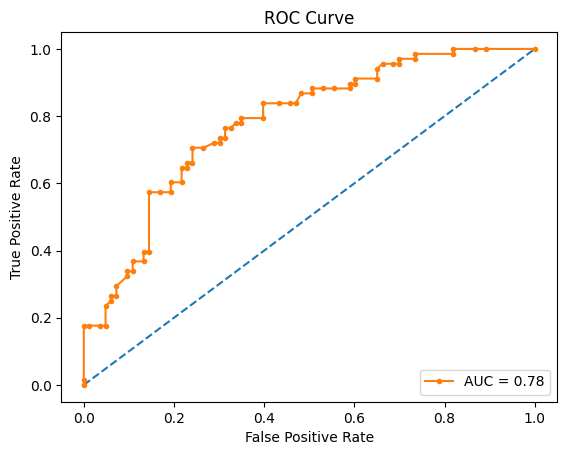

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot([0, 1], [0, 1], linestyle="--")  # plot random curve
plt.plot(
    tpr,
    fpr,
    marker=".",
    label=f"AUC = {round(roc_auc_score(y_test, prediction_prob), 2)}",
)
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

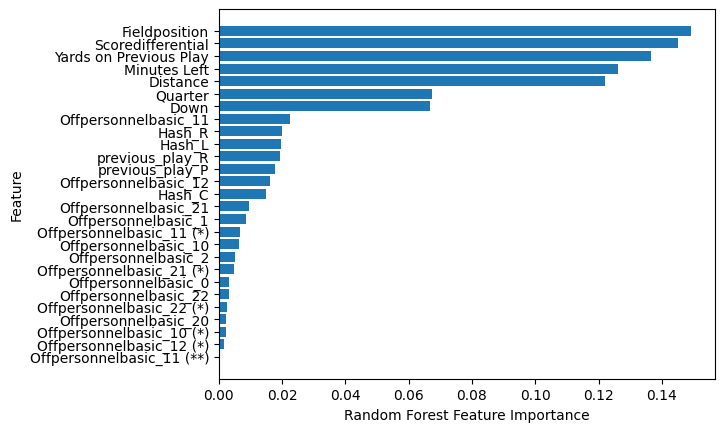

In [12]:
important_features = pd.Series(data=forest.feature_importances_, index=predictors)
important_features.sort_values(ascending=True, inplace=True)
index = range(len(important_features))

plt.figure()
plt.barh(index, important_features, height=0.8)
plt.ylabel("Feature")
plt.yticks(index, important_features.index)
plt.xlabel("Random Forest Feature Importance")
plt.show()

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
labeled = le.fit_transform(y_resampled)
labeled_test = le.fit_transform(y_test)

xgbc = xgb.XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    grow_policy="lossguide",
    max_depth=0,
    n_estimators=1000,
    random_state=0,
)

xgbc.fit(x_resampled, labeled)

predictions = xgbc.predict(x_test)

print(classification_report(labeled_test, predictions))
print(confusion_matrix(labeled_test, predictions))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72        83
           1       0.66      0.63      0.65        68

    accuracy                           0.69       151
   macro avg       0.69      0.68      0.68       151
weighted avg       0.69      0.69      0.69       151

[[61 22]
 [25 43]]


In [ ]:
# creating deepcopy of default parameters before manipulations
from copy import deepcopy
from time import time

from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from skopt import BayesSearchCV
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

pd.set_option("mode.chained_assignment", None)

results_dict = {}

le = LabelEncoder()
labeled = le.fit_transform(y_train).astype("int32")
labeled_test = le.fit_transform(y_test)


# setting grid of selected parameters for iteration
params = {
    "gamma": [0, 0.1, 0.2, 0.4],
    "learning_rate": [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.6, 0.7],
}
xgbc = xgb.XGBClassifier(
    objective="binary:logistic",
    booster="gbtree",
    eval_metric="auc",
    tree_method="hist",
    grow_policy="lossguide",
    n_estimators=1000,
    random_state=0,
)

clf = BayesSearchCV(
    estimator=xgbc,
    search_spaces=params,
    scoring="roc_auc",
    return_train_score=True,
    cv=3,
    n_jobs=-1,
    n_iter=10,
    random_state=0,
)
clf.fit(x_train, labeled)

train_predictions = clf.predict(x_train)
test_predictions = clf.predict(x_test)

train_accuracy = accuracy_score(labeled, le.inverse_transform(train_predictions))
test_accuracy = accuracy_score(labeled_test, le.inverse_transform(test_predictions))


# best parameters
bp = clf.best_params_


print(f"train accuracy {train_accuracy}")
print(f"test accuracy {test_accuracy}")
print(bp)

print(f"best roc_auc score: {clf.best_score_}")
print(f"test roc_auc score: {clf.score(x_test, labeled_test)}")
print(f"parameters: {clf.best_estimator_.get_params()}")